In [20]:
import cv2
import json
import os
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scipy.ndimage as nd

## FEtaure extraction

In [76]:
import cv2
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scipy.ndimage as nd
from skimage.feature import hog




In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from skimage.measure import euler_number

In [78]:
tools = ['accendino', 'cacciavite', 'chiave', 'forbici', 'martello', 'metro','nastro', 'pappagallo', 'penna', 'spillatrice']
feat_hog = []
feat_euler = []
y_labels = []


# Caricamento dell'immagine segmentata
cwd = os.getcwd()
folder_path = os.path.join(cwd, f"images")

for tool in tqdm(tools):

    with open(f"{folder_path}\{tool}\{tool}_gt.json", 'r') as f:
        ground_truth_file = json.load(f)

    for pos, el in enumerate(ground_truth_file):

        truth_mask = np.zeros((520, 520))
        image = cv2.imread(f"{folder_path}\{tool}\{tool}_{pos+1}.png")

        for i in range(len(ground_truth_file[el]['regions'])):

            x_pos = ground_truth_file[el]['regions'][i]['shape_attributes']['all_points_x']
            y_pos = ground_truth_file[el]['regions'][i]['shape_attributes']['all_points_y']
            vertices = np.array([[x_pos[u], y_pos[u]] for u in range(len(x_pos))])
            if i == 0:
                    cv2.fillPoly(truth_mask, [vertices], 255)
            else:
                    cv2.fillPoly(truth_mask, [vertices], 0)

        # Ground truth.
        x_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_x']
        y_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_y']
        vertices = np.array([[x_pos[i], y_pos[i]] for i in range(len(x_pos))])
        truth_mask = truth_mask.astype(bool)

        # Immagine segmentata.
        segmented = np.zeros_like(image)
        segmented[truth_mask] = image[truth_mask]
        


        # HOG
        orientations = 9
        pixels_per_cell = (8, 8)
        cells_per_block = (2, 2)

        hog_features = hog(segmented, orientations=orientations, pixels_per_cell=pixels_per_cell,
                        cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=False, channel_axis=-1)
        
        # Numero di Eulero
        euler = euler_number(segmented)




        

        y_labels.append(tool)
        feat_hog.append(hog_features)
        feat_euler.append(euler)


all_features = np.column_stack((feat_hog, feat_euler))

100%|██████████| 10/10 [00:39<00:00,  3.94s/it]


In [ ]:
# Carica le feature estratte dall'immagine segmentata
X = all_features

# Carica le etichette di classe associate all'immagine segmentata
y = y_labels

# Dividi il dataset in un set di training e un set di test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crea un albero decisionale
clf = DecisionTreeClassifier()

# Addestra il modello sull'insieme di training
clf.fit(X_train, y_train)

# Fai una previsione sul set di test
y_pred = clf.predict(X_test)

# Valuta la precisione del modello
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)
cm = np.array(cm)
col_sums = cm.sum(axis=0)
cm = cm / col_sums[np.newaxis, :]

Accuracy: 0.325


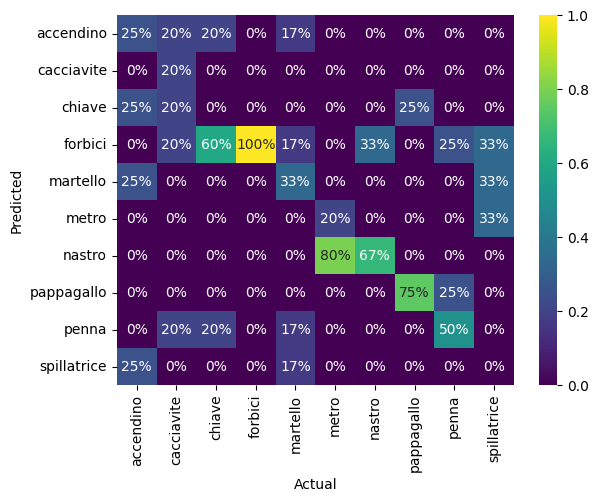

In [98]:
print("Accuracy:", accuracy)
sns.heatmap(cm, annot=True, cmap='viridis', xticklabels=tools, yticklabels=tools, fmt=".0%")
plt.xlabel('Actual')
plt.ylabel('Predicted');